# Integration and Visualization
- YOUR NAME:
- YOUR VUNetID:

(If you do not provide your NAME and VUNetID we will not accept your submission.)


## Task 1 (2 Points):  Integrating ontologies in Protégé
Take the ontology you built for Module 4 (let’s call it ontology A), and find either a fellow student with a similar ontology or an ontology on the web on similar domain. That will be our ontology B. 

Create an empty ontology in Protégé (ontology C), and import both ontologies. 

Define at least 6 mappings as following:

-    1 mapping between a class from A and a class from B using rdfs:subClassOf 
-    1 mapping between a class from A and a class from B using owl:equivalentClass
-    1 mapping between a property from A and a property from B using rdfs:subPropertyOf
-    1 mapping between a property from A and a property from B using either owl:equivalentProperty, owl:disjointProperty, owl:inverseOf, or owl:propertyChainAxiom
-    1 mapping between an individual from A and an individual from B using owl:differentFrom
-    1 mapping between an individual from A and an individual from B using owl:sameAs 

The combined ontology should be **consistent**.

Save the ontology as Turtle, where the filename is ‘mapping.ttl’

Add all three ontologies to the ZIP file of this assignment, leaving preserved the original file names of the ontologies (i.e. the ones with the vunetIDs).

In [7]:
print(open('mapping.ttl').read())

FileNotFoundError: [Errno 2] No such file or directory: 'mapping.ttl'

## Task 2 (1 Point):  Explain your mapping

Please explain in a few sentences in the text field below the mapping you made in the previous question:

...

## Task 3 (2 points):  Integration with SPARQL

Before starting this task, make sure to watch the demo given in Lecture 10.

Follow these instructions to complete this task:

1.    Open your GraphDB workbench.
2.    Create a new repository called assignment-5, and import your ontology A into this repository (you must have at least provided the Ontology A in the previous question).
3.    Given your initial ontology A and the domain it covers, find on the Web a public SPARQL endpoint that provides similar or complementary information (e.g. DBpedia, Wikidata, LinkedGeoData).
4.    From the SPARQL interface in GraphDB, write a SELECT query that you can use to retrieve this complementary or similar information from the SPARQL endpoint.
5.    Now also from the SPARQL interface in GraphDB, write an INSERT query to define mappings between the retrieved data and your ontology A. These mappings can be between classes in your ontology and classes in the retrieved data (e.g. using rdfs:subClassOf), between instances (e.g. using owl:sameAs), or between instances and classes (e.g. using rdf:type).
6.    After creating the mappings in GraphDB, export your RDF data, and check in Protégé if your ontology is consistent.
7.    If your ontology is still consistent, paste here both the SELECT query (step 4) and the INSERT query (step 5) that created these mappings. Otherwise, go back to Step 4.

SELECT:
```sparql
SELECT ...
```

INSERT:
```sparql
INSERT ...
```

In [1]:
%pip install ipython-sparql-pandas
# run `sparql?` in a cell for documentation
%load_ext ipython_sparql_pandas

Note: you may need to restart the kernel to use updated packages.


## Task 4 (2 point). Pandas Plotting
First, make sure that `vuDataset.ttl` is loaded in GraphDb as the `repo-vu` repository.

- **Task 4a:** Make a horizontal bar chart from the `courseload` dataframe
- **Task 4b:** Write a new SPARQL query for DBpedia and create an interesting chart from it

In [2]:
%%sparql http://localhost:7200/repositories/repo-vu -s courseload
PREFIX vu: <http://example.org/vu/>

SELECT ?teacher (COUNT(*) as ?courses) {
    ?teacher vu:teaches ?o .
} GROUP BY ?teacher

,teacher,courses
0,http://example.org/vu/stefan,5
1,http://example.org/vu/frank,3
2,http://example.org/vu/joe,1


<AxesSubplot:ylabel='courses'>

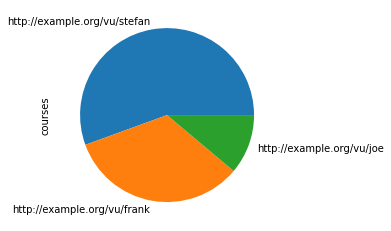

In [3]:
# Pandas visualization: https://pandas.pydata.org/docs/user_guide/visualization.html
courseload.set_index('teacher', inplace=True)
courseload['courses'].plot.pie()

In [4]:
### Task 4a (1 point): Make a horizontal bar chart from the `courseload` dataframe

In [5]:
### Task 4b (1 point): Write a new SPARQL query for DBpedia 
###    and create an interesting chart from it

## Task 5 (1 point). Pandas styling
Below is some code that shows a colored table.

**Task:** Add a column with the percentage of the area of the country that is water.
The background color of this column depend on its value: it should greener if more the country is land, and bluer if more of the country is water.

In [6]:
%%sparql http://dbpedia.org/sparql/ -q -s dbpedia_countries
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcb: <http://dbpedia.org/resource/Category:>
PREFIX dbo: <http://dbpedia.org/ontology/>

SELECT DISTINCT ?name ?area_100k_km2 ?giniCoefficient WHERE {
    ?country 
        dct:subject dcb:Current_member_states_of_the_United_Nations ;
        dbo:area ?area ; # area is stated in m^2
        dbo:giniCoefficient ?giniCoefficient ;
        rdfs:label ?name. 
    
    BIND (ROUND(?area/100000000000) AS ?area_100k_km2)
    FILTER(LANG(?name) = 'en')
}
ORDER BY DESC(?area_100k_km2)
LIMIT 50

In [7]:
# Styling: https://pandas.pydata.org/docs/user_guide/style.html
# Using CSS Hue-Saturation-Level colors: https://www.w3schools.com/colors/colors_hsl.asp

def gini_color(gini):
    return f'background: hsl({100 - gini}, 100%, 50%)' 

dbpedia_countries.style \
    .applymap(gini_color, subset=(slice(None), "giniCoefficient"))

,name,area_100k_km2,giniCoefficient
0,Russia,171.000000,37.500000
1,Canada,100.000000,30.300000
2,United States,98.000000,48.500000
3,China,96.000000,46.700000
4,Brazil,85.000000,53.400000
5,Australia,77.000000,32.500000
6,India,33.000000,35.700000
7,Argentina,28.000000,42.900000
8,Kazakhstan,27.000000,27.500000
9,Algeria,24.000000,27.600000


# Task 6 (2 points): Folium Map

Below is some code that makes a map. 

**Task:** Make the markers bigger depending on the population of the capital (but keep it readable!)

Tip: use the auto-complete functionality of http://query.wikidata.org

In [9]:
%%sparql http://query.wikidata.org/sparql -q -s capitals
SELECT ?capitalLabel ?coords WHERE {
    ?country
        wdt:P463 wd:Q458 ; # member of: European Union
        wdt:P36 ?capital . # capital: ?capital
        
    ?capital 
        wdt:P625 ?coords . # coordinate location: ?coords
    
    # Using Wikidata-only label service
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}

In [10]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [11]:
import folium
# Extract latitude and longitude from coordinates in Well-Known Text (WKT) format
capitals_coords = capitals.join(capitals.coords.str.extract('Point\((?P<lon>\S+) (?P<lat>\S+)\)').astype(float))

middle = [capitals_coords['lat'].mean(), capitals_coords['lon'].mean()]
m = folium.Map(location=middle, zoom_start=4)
for _, row in capitals_coords.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius= 20,
        popup= row['capitalLabel'],
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
    ).add_to(m)

m